# Analysis

Analysis performed with Linear Regression and pymc3.  Options are available for number of chillers in training set as well as combination of features.

Read data files from multiple chillers and create a model

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import RidgeCV
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import mean_squared_error
from sklearn.linear_model    import Lasso
from sklearn                 import linear_model
from sklearn.ensemble        import RandomForestRegressor
from sklearn.preprocessing   import StandardScaler

from pymc3 import Model, sample, Normal, HalfCauchy, Cauchy, HalfNormal, Uniform, model_to_graphviz
import pymc3 as pm

import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt

import pickle

%matplotlib inline

import re
import glob


# import custome utility functions
from util import plot_curves
from util import get_Xy
#from util import compute_lift_lines

## LASSO

In [ ]:
'''
ChList = (['1T1','1T2','1T3','1T4','1T5','1T6','1T7','1T8','1T9','1T10','1T11','1T12',
             '5T14','5T16','5T18','5T20',
             'B1','B2','B3','B4',
             'BC1','BC2',
             'C1','C2','C3','C4',
             'S1','S2','S3','S4'])
'''

ChList = (['B1','B2','B3','B4',
             'C1','C2','C3','C4',
             'S1','S2','S3','S4'])

df_all = Plants_to_one_file(ChList)
data_file = 'data/ALL_chillers.csv'
df_all.to_csv(data_file)

#feat = ['HigherOrder','ModelInfo']
feat = ['HigherOrder','ReducedModelInfo','ModelInfoHigherOrder']
#feat = ['HigherOrder']

X, y, df = new_get_Xy(data_file,feat)

print(X.shape)
print(X.dropna().shape)

#divide in to train and test sets
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


In [ ]:
lr_lasso = linear_model.Lasso(alpha=0.1)
lr_fit = lr_lasso.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
lr_lasso.score(X_train,y_train)

In [ ]:
#alpha_list = [1e-4, 1e-3, 1e-2, .05, 1e-1,.3,.5,.7]
#alpha_list = [5e-6, 1e-5, 5e-5, 1e-4,5e-4,1e-3]
alpha_list = [1e-5, 5e-5, 1e-4,5e-4]

lasso_results = []
for alpha in alpha_list:
    lr_lasso = linear_model.Lasso(alpha=alpha)
    lr_lasso_fit = lr_lasso.fit(X_train, y_train)

    score = lr_lasso.score(X_train,y_train)
    RMSE = sqrt(mean_squared_error(y_test, lr_lasso.predict(X_test)))
    coef = lr_lasso_fit.coef_.tolist()
    #print(coef)
    lasso_results.append([alpha,score,coef,RMSE])

In [ ]:
X_train.columns

In [ ]:
num_features = X_train.shape[1]

p = 0
num_plots = len(lasso_results)
fig, axes = plt.subplots(nrows=(num_plots+1)//2, ncols=2, figsize=(15, int(num_plots/2)*4))

for alpha,score,coef,RMSE in lasso_results:
    #print(alpha,score,coef)
    test = (alpha == 0.7)
    test = True
    plt.setp(axes, xticks=np.linspace(0,num_features+1, num=num_features+2), 
#             xticklabels=['','Load','DTLift','Load^2','DTLift^2',
#                          'Load*DTLift','Load*DTLift^2','Load^2*DTLift'],
#             ylim=(-.1,.2),
             ylim=(-.001,.001),
             xlim=(0.5,num_features+.5))

    if test:
        axes[p//2,p%2].bar(range(1,num_features+1),coef,
                           label=f"alpha={alpha}, R^2={score:.2g}",
                           color='green',edgecolor='green')
        axes[p//2,p%2].set_xlabel("Feature")
        axes[p//2,p%2].set_ylabel("Lasso Coefficient")
        axes[p//2,p%2].legend()

        p +=1
        
if num_plots%2 == 1:
    axes[num_plots//2, 1].remove()  # don't display empty plot

plt.show()

In [ ]:
X_train.columns

## York Curves

In [ ]:
york

In [ ]:
york = pd.read_csv('data/Chiller_Characteristics/YorkCurves.csv')

X1 = pd.DataFrame()
y1 = pd.DataFrame()
X2 = pd.DataFrame()
y2 = pd.DataFrame()

X1['Load'] = york['Load']
X1['Load^2'] = york['Load']**2
y1['kW/Ton'] = york['YKKJKLH9-CWF']

# Create an empty model
lr = LinearRegression()

# Fit the model to the full dataset
lr.fit(X1, y1)

# Print out the R^2 for the model against the full dataset
print(lr.intercept_)
print(lr.coef_)

X2 = X1.copy()

y2['kW/Ton'] = york['YKPFP4K2-FBG']
lr.fit(X1, y2)
print(lr.intercept_)
print(lr.coef_)


In [ ]:
X1['ModelNo'] = 'YKKJKLH9-CWF'
X2['ModelNo'] = 'YKPFP4K2-FBG'

In [ ]:
ModelCharacteristics = pd.read_csv('data/Chiller_Characteristics/ModelCharacteristics.csv')
X1 = pd.merge(X1, ModelCharacteristics, on='ModelNo')
X2 = pd.merge(X2, ModelCharacteristics, on='ModelNo')


In [ ]:
X = X1.append(X2,sort=False)
y = y1.append(y2,sort=False)

In [ ]:
X = X.dropna(axis=1)
X = X.drop(columns='ModelNo')

In [ ]:
X.columns

In [ ]:
lr_lasso = linear_model.Lasso(alpha=0.1)
lr_fit = lr_lasso.fit(X, y)

# Print out the R^2 for the model against the full dataset
lr_lasso.score(X,y)

In [ ]:
alpha_list = [1e-5, 1e-4,1e-3, 1e-2,1e-1]

lasso_results = []
for alpha in alpha_list:
    lr_lasso = linear_model.Lasso(alpha=alpha)
    lr_lasso_fit = lr_lasso.fit(X, y)

    score = lr_lasso.score(X,y)
    RMSE = sqrt(mean_squared_error(y, lr_lasso.predict(X)))
    coef = lr_lasso_fit.coef_.tolist()
    #print(coef)
    lasso_results.append([alpha,score,coef,RMSE])

In [ ]:
num_features = X.shape[1]

p = 0
num_plots = len(lasso_results)
fig, axes = plt.subplots(nrows=(num_plots+1)//2, ncols=2, figsize=(15, int(num_plots/2)*4))

for alpha,score,coef,RMSE in lasso_results:
    #print(alpha,score,coef)
    test = (alpha == 0.7)
    test = True
    plt.setp(axes, xticks=np.linspace(0,num_features+1, num=num_features+2), 
             ylim=(-.001,.001),
#             xlim=(0.5,num_features+.5)
            )

    if test:
        axes[p//2,p%2].bar(range(1,num_features+1),coef,
                           label=f"alpha={alpha}, R^2={score:.2g}",
                           color='green',edgecolor='green')
        axes[p//2,p%2].set_xlabel("Feature")
        axes[p//2,p%2].set_ylabel("Lasso Coefficient")
        axes[p//2,p%2].legend()

        p +=1
        
if num_plots%2 == 1:
    axes[num_plots//2, 1].remove()  # don't display empty plot

plt.show()

In [ ]:
X_new = X[['Load','Load^2','RatedTons']]
lr.fit(X_new, y)

print(lr.intercept_)
print(lr.coef_)

In [ ]:
X_new = X[['Load','Load^2','RatedTons','CDesFlow']]
lr.fit(X_new, y)

print(lr.intercept_)
print(lr.coef_)

## Functions

In [2]:
def Plants_to_one_file(PlantList):
    PlantToModel = pd.read_csv('data/Chiller_Characteristics/PlantToModel.csv')
    PlantToModel.set_index('Plant',inplace=True)
    ModelCharacteristics = pd.read_csv('data/Chiller_Characteristics/ModelCharacteristics.csv')

    df_all = pd.DataFrame()

    for Plant in PlantList:
        file = 'data/'+Plant+'_chiller.csv'
        foo = re.match('(\d*[A-Z]+)(\d+)',Plant)
        if foo is None:
            raise AttributeError(f'could not match {file}')

        PlantCode = foo.group(1)
        ChCode = foo.group(2)

        print(f'opening file: {file}        plant code: {PlantCode}        chiller code: {ChCode}')

        df = pd.read_csv(file)
        
        ModelNo = PlantToModel.loc[PlantCode+ChCode]['Model']
        df['ModelNo'] = ModelNo
        df['Chiller'] = PlantCode+ChCode

        df = pd.merge(df, ModelCharacteristics, on='ModelNo')
        df_all = df_all.append(df)
    
    return(df_all)

In [3]:
def new_get_Xy(file_name,features=[]):
    df = pd.read_csv(file_name)

    if 'ModelNo' not in df.columns:
        print('getting model info')
        
        foo = re.match('data/(\d*[A-Z]+)(\d+)_chiller.csv',file_name)
        if foo is None:
            raise AttributeError(f'could not match {file_name}')

        PlantCode = foo.group(1)
        ChCode = foo.group(2)

        print(f'opening file: {file_name}        plant code: {PlantCode}        chiller code: {ChCode}')

        PlantToModel = pd.read_csv('data/Chiller_Characteristics/PlantToModel.csv')
        PlantToModel.set_index('Plant',inplace=True)
        ModelCharacteristics = pd.read_csv('data/Chiller_Characteristics/ModelCharacteristics.csv')

        ModelNo = PlantToModel.loc[PlantCode+ChCode]['Model']
        df['ModelNo'] = ModelNo
        df['Chiller'] = PlantCode+ChCode

        df = pd.merge(df, ModelCharacteristics, on='ModelNo')    

    # remove rows with NaN on primary features
    num_rows = df.shape[0]
    df.dropna(subset=['Load','DTLift','kW/Ton'],inplace=True)
    df.reset_index(inplace=True)
    print('DataFrame rows with NaN removed: ',num_rows - df.shape[0])

    y = df['kW/Ton'].copy()
    X = df[['Load','DTLift']].copy()

    if 'HigherOrder' in features:
        X['Load^2']        = df['Load']**2
        X['Load*DTLift']   = df['Load']*df['DTLift']
        X['Load^2*DTLift'] = (df['Load']**2)*df['DTLift']
            
    X = add_features(X, df,features)
    
    print('X with all features',X.shape)

#     if 'ModelInfo' in features:  
#         X['RatedTons']  = df['RatedTons']
#         X['VarSpeed']   = df['VarSpeed']
#         X['RatedkW']    = df['RatedkW']
#         X['CDesFlow']   = df['CDesFlow']
#         X['CPDrop']     = df['CPDrop']
#         X['CEnterTemp'] = df['CEnterTemp']
#         X['CLeaveTemp'] = df['CLeaveTemp']
#         X['EDesFlow']   = df['EDesFlow']
#         X['EPDrop']     = df['EPDrop']
#         X['EEnterTemp'] = df['EEnterTemp']
#         X['ELeaveTemp'] = df['ELeaveTemp']
#     if 'ReducedModelInfo' in features:
#         X['RatedTons']  = df['RatedTons']
#         X['VarSpeed']   = df['VarSpeed']
#         X['CDesFlow']   = df['CDesFlow']
#     if 'ModelInfoHigherOrder' in features:
#         X['RatedTons_Load']          = df['RatedTons']*df['Load']
#         X['RatedTons_DTLift']        = df['RatedTons']*df['DTLift']
#         X['RatedTons_Load^2']        = df['RatedTons']*df['Load']**2
#         X['RatedTons_Load*DTLift']   = df['RatedTons']*df['Load']*df['DTLift']
#         X['RatedTons_Load^2*DTLift'] = df['RatedTons']*df['DTLift']*df['Load']**2
#         X['CDF_Load']          = df['CDesFlow']*df['Load']
#         X['CDF_DTLift']        = df['CDesFlow']*df['DTLift']
#         X['CDF_Load^2']        = df['CDesFlow']*df['Load']**2
#         X['CDF_Load*DTLift']   = df['CDesFlow']*df['Load']*df['DTLift']
#         X['CDF_Load^2*DTLift'] = df['CDesFlow']*df['DTLift']*df['Load']**2

    return X, y, df

In [4]:
def compute_lift_lines(model, features, df, plot=True):
    col_list = ['blue','red','green','gold','purple']
    lift_lines = {}

    if plot:
        plt.figure(figsize=(7,5))
        plt.ylim(0,1)
        plt.xlim(0,1)
        plt.legend()
        plt.xlabel('Load')
        plt.ylabel('xW/Ton')
        plt.grid(True)
    

    X_line = pd.DataFrame()
#    for lift in range(10,60,10):
    for lift in range(5,65,5):
        X_line['Load'] = np.arange(0.2,1,0.8/80)
        X_line['DTLift'] = lift*np.ones(80)
        if 'HigherOrder' in features:
            X_line['Load^2'] = X_line['Load']**2
            X_line['Load*DTLift'] = X_line['Load']*X_line['DTLift']
            X_line['Load^2*DTLift'] = (X_line['Load']**2)*X_line['DTLift']
        
        X_line = add_features(X_line.copy(),df.copy(),features)
        
        try:
            y_line = model.predict(X_line)
        except:
            print('failed to compute y_line \n',X_line)
        
        lines = []
        lines.append(X_line['Load'])
        lines.append(y_line)
        lift_lines[lift] = lines
        if (lift+5)%10 == 0:
            if plot:
                plt.plot(list(X_line['Load']),y_line,c=col_list[0],label=f'{lift+5} degrees F Lift')
            try:
                col_list.pop(0)
            except:
                print(' ')

    return lift_lines

def compute_lift_lines_pymc3(pymc3_coef, X_scaler, features, plot=True):
    col_list = ['blue','red','green','gold','purple','orange']
    lift_lines = {}

    if plot:
        plt.figure(figsize=(7,5))
        plt.ylim(0,1)
        plt.xlim(0,1)
   

    X_line = pd.DataFrame()
#    for lift in range(10,60,10):
    for lift in range(5,65,5):
        X_line['Load'] = np.arange(0.2,1,0.8/80)
        X_line['DTLift'] = lift*np.ones(80)
        if 'HigherOrder' in features:
            X_line['Load^2'] = X_line['Load']**2
            X_line['Load*DTLift'] = X_line['Load']*X_line['DTLift']
            X_line['Load^2*DTLift'] = (X_line['Load']**2)*X_line['DTLift']
                
        y_line = pymc3_yline(X_line,pymc3_coef,X_scaler,features)
        
        lines = []
        lines.append(X_line['Load'])
        lines.append(y_line)
        lift_lines[lift] = lines
        if lift%10 == 0:
            if plot:
#                plt.plot(list(X_line['Load']),y_line,c=col_list[0],label=f'{lift+5} degrees F Lift')
                plt.plot(list(X_line['Load']),y_line,c=col_list[0],label=f'{lift} degrees F Lift')
            try:
                col_list.pop(0)
            except:
                print(' ')

                
    if plot:
        plt.legend()
        plt.xlabel('Load')
        plt.ylabel('xW/Ton')
        plt.grid(True)
         
    return lift_lines


def pymc3_yline(X_line,pymc3_coef, X_scaler, features):
    X_line_scaled = pd.DataFrame(X_scaler.transform(X_line), columns=X_line.columns)

    y_line = pd.DataFrame()
    if 'HigherOrder' in features:        
        y_line = (pymc3_coef['Intercept'] +
                  pymc3_coef['Load']     *X_line_scaled['Load'] +
                  pymc3_coef['Load2']    *X_line_scaled['Load^2'] +
                  pymc3_coef['LoadLift'] *X_line_scaled['Load*DTLift'] +
                  pymc3_coef['Load2Lift']*X_line_scaled['Load^2*DTLift'] +
                  pymc3_coef['Lift']     *X_line_scaled['DTLift']
                 )
    return y_line

In [5]:
def add_features(X, df_in,features):
    if len(X) < len(df_in):
        df = df_in.dropna(subset=['RatedTons'])

        df = df.copy().head(len(X))
    else:
        df = df_in.copy()
    df.reset_index(inplace=True)
#    print('input df',len(df_in),'input X',len(X))
    
    if 'ModelInfo' in features:  
        X['RatedTons']  = df['RatedTons']
        X['VarSpeed']   = df['VarSpeed']
        X['RatedkW']    = df['RatedkW']
        X['CDesFlow']   = df['CDesFlow']
        X['CPDrop']     = df['CPDrop']
        X['CEnterTemp'] = df['CEnterTemp']
        X['CLeaveTemp'] = df['CLeaveTemp']
        X['EDesFlow']   = df['EDesFlow']
        X['EPDrop']     = df['EPDrop']
        X['EEnterTemp'] = df['EEnterTemp']
        X['ELeaveTemp'] = df['ELeaveTemp']
        
    if 'ReducedModelInfo' in features:        
#         df['RatedTons'].fillna(method='pad',inplace=True)
#         df['CDesFlow'].fillna(method='pad',inplace=True)
#         df['VarSpeed'].fillna(method='pad',inplace=True)
    
        X['RatedTons']  = df['RatedTons']
        X['VarSpeed']   = df['VarSpeed']
        X['CDesFlow']   = df['CDesFlow']
                
#        X['RatedTons'].fillna(method='pad',inplace=True)
#        X['CDesFlow'].fillna(method='pad',inplace=True)
#        X['VarSpeed'].fillna(method='pad',inplace=True)

    if 'ModelInfoHigherOrder' in features:
#        df['RatedTons'].fillna(method='pad',inplace=True)
#        df['CDesFlow'].fillna(method='pad',inplace=True)

        X['RatedTons_Load']          = df['RatedTons']*X['Load']
#        X['RatedTons_DTLift']        = df['RatedTons']*X['DTLift']
        X['RatedTons_Load^2']        = df['RatedTons']*X['Load^2']
#        X['RatedTons_Load*DTLift']   = df['RatedTons']*X['Load*DTLift']
#        X['RatedTons_Load^2*DTLift'] = df['RatedTons']*X['Load^2*DTLift']
        X['CDF_Load']          = df['CDesFlow']*X['Load']
#        X['CDF_DTLift']        = df['CDesFlow']*X['DTLift']
        X['CDF_Load^2']        = df['CDesFlow']*X['Load^2']
#        X['CDF_Load*DTLift']   = df['CDesFlow']*X['Load*DTLift']
#        X['CDF_Load^2*DTLift'] = df['CDesFlow']*X['Load^2*DTLift']

        X['CPD_Load']          = df['CPDrop']*X['Load']
        X['CPD_Load^2']        = df['CPDrop']*X['Load^2']

        X['EDF_Load']          = df['EDesFlow']*X['Load']
        X['EDF_Load^2']        = df['EDesFlow']*X['Load^2']

        X['EDP_Load']          = df['EPDrop']*X['Load']
        X['EDP_Load^2']        = df['EPDrop']*X['Load^2']
        
#        EAstd = df_in['EvapApproach'].std()
#        X['EA_Load']          = EAstd*X['Load']
#        X['EA_DTLift']        = EAstd*X['DTLift']
#        X['EA_Load^2']        = EAstd*X['Load^2']
#        X['EA_Load*DTLift']   = EAstd*X['Load*DTLift']
#        X['EA_Load^2*DTLift'] = EAstd*X['Load^2*DTLift']
        
    return X

In [6]:
def Ch_Results(Chiller,feat,lr):

    data_file = 'data/'+Chiller+'_chiller.csv'
    X_test, y_test, df = new_get_Xy(data_file,feat)
    print(Chiller+':',X_train.shape,y_train.shape)
    print('R^2: ',lr.score(X_test,y_test))
    
    lift_lines = compute_lift_lines(lr, feat, df, plot=False)
    plot_curves(df,lift_lines,'Chiller '+Chiller)



In [7]:
from matplotlib import cm

def pltcolor(lift,col_list):
    cols=[]
    for l in lift:
        if l <= [*col_list][0]:
            cols.append('gray')
        elif (l > [*col_list][0]) and (l <= [*col_list][1]):
            cols.append(col_list[[*col_list][0]])
        elif (l > [*col_list][1]) and (l <= [*col_list][2]):
            cols.append(col_list[[*col_list][1]])
        elif (l > [*col_list][2]) and (l <= [*col_list][3]):
            cols.append(col_list[[*col_list][2]])
        elif (l > [*col_list][3]) and (l <= [*col_list][4]):
            cols.append(col_list[[*col_list][3]])
        elif (l > [*col_list][4]) and (l <= [*col_list][4]+10):
            cols.append(col_list[[*col_list][4]])
        elif (l > [*col_list][4]):
            cols.append('gray')
    return cols

def pltcolor1(lift):
    cmap = cm.get_cmap('rainbow')

    c_max = 60
    c_min = 10
    c_factor = 1/(c_max-c_min)

    cols = []
    for l in lift:
        cols.append((l-c_min)*c_factor)
            
    return cols


def plot_all_curves(ChList,feat,model,savefile=''):
    
    num_plots = len(ChList)
    fig, axes = plt.subplots(nrows=(num_plots+1)//2, ncols=2, figsize=(15, int(num_plots/2)*7))

    cmap = cm.get_cmap('rainbow')

    c_max = 60
    c_min = 10
    c_factor = 1/(c_max-c_min)

    col_list = {10:cmap((10-c_min)*c_factor),
                20:cmap((20-c_min)*c_factor),
                30:cmap((30-c_min)*c_factor),
                40:cmap((40-c_min)*c_factor),
                50:cmap((50-c_min)*c_factor)
               }

#    col_list = { 10:'blue',
#                 20:'red',
#                 30:'green',
#                 40:'gold',
#                 50:'purple'
#               }

    p = 0
    for Chiller in ChList:
        
        plt.setp(axes, ylim=(0,1), xlim=(0,1))

        data_file = 'data/'+Chiller+'_chiller.csv'
        X_test, y_test, df = new_get_Xy(data_file,feat)
        RMSE = sqrt(mean_squared_error(y_test, model.predict(X_test)))

        R2 = model.score(X_test,y_test)
        
        print(f'Chiller {Chiller}: RMSE={RMSE}, R2={R2}')
        
        lift_lines = compute_lift_lines(model, feat, df, plot=False)
        
        pickle.dump(lift_lines,open('data/'+Chiller+'lift_lines.pkl','wb'))
        
        for key in lift_lines:
            x_line = lift_lines[key][0]
            y_line1 = lift_lines[key][1]
            if key in col_list:
                y_line2 = lift_lines[key+10][1]
                # plot points off the print area for legend - to have no transparancy
                axes[p//2,p%2].scatter([-1], [-1], c=col_list[key], s=10,
                                    label=f'{key}-{key+10}$^0$ F Lift')

                axes[p//2,p%2].fill_between(x_line, y_line1, y_line2, facecolor=col_list[key], 
                                            alpha=0.1)
#            if key in col_list:
#                axes[p//2,p%2].plot(x_line,y_line1,c='white',linewidth=3.0)            
#                axes[p//2,p%2].plot(x_line,y_line1,c=col_list[key],linewidth=1.0,label=f'{key} degrees F Lift')
            
        # call function to set the bands of colors
        bands = pltcolor(list(df['DTLift']),col_list)
#        bands = pltcolor1(list(df['DTLift']))
        
        axes[p//2,p%2].scatter(x=df['Load'],y=df['kW/Ton'],s=2,c=bands,label='',alpha=0.9)
 
        axes[p//2,p%2].set_xlabel("Load")
        axes[p//2,p%2].set_ylabel("kW/Ton")
        
        axes[p//2,p%2].legend(loc="upper left",handletextpad=-.1)
            
        axes[p//2,p%2].set_title(f'{Chiller} with $R^2$={R2:.2g}')
        
        for key in lift_lines:
            if (key in col_list) or (key-10 in col_list):
                y_line1 = lift_lines[key][1]
                axes[p//2,p%2].plot(x_line,y_line1,c='gray',linewidth=1)            
        
        
#        if (Chiller == 'B1') or (Chiller == 'B2') or (Chiller == 'B3'):
#            york = pd.read_csv('data/Chiller_Characteristics/YorkCurves.csv')
#            axes[p//2,p%2].plot(york['Load']/100.,york['YKKJKLH9-CWF'],c='black',marker='o',linewidth=2.0) 

#        elif (Chiller == 'S1') or (Chiller == 'S2') or (Chiller == 'S3') or (Chiller == 'S4'):
#            york = pd.read_csv('data/Chiller_Characteristics/YorkCurves.csv')
#            axes[p//2,p%2].plot(york['Load']/100.,york['YKPFP4K2-FBG'],c='black',marker='o',linewidth=2.0)            
            
        p +=1
        
    if num_plots%2 == 1:
        axes[num_plots//2, 1].remove()  # don't display empty plot

    if savefile != '':
#        fig = plt.figure()
        fig.savefig(savefile)

    plt.show()


getting model info
opening file: data/C1_chiller.csv        plant code: C        chiller code: 1
DataFrame rows with NaN removed:  1389
X with all features (34591, 18)
Chiller C1: RMSE=0.030684374973141873, R2=0.9180213201035681


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

getting model info
opening file: data/C2_chiller.csv        plant code: C        chiller code: 2
DataFrame rows with NaN removed:  9762
X with all features (24823, 18)
Chiller C2: RMSE=0.0676858152380804, R2=0.5331582497878224
 
getting model info
opening file: data/B1_chiller.csv        plant code: B        chiller code: 1
DataFrame rows with NaN removed:  132
X with all features (32881, 18)
Chiller B1: RMSE=0.04027706893963525, R2=0.9065629681694105
 


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

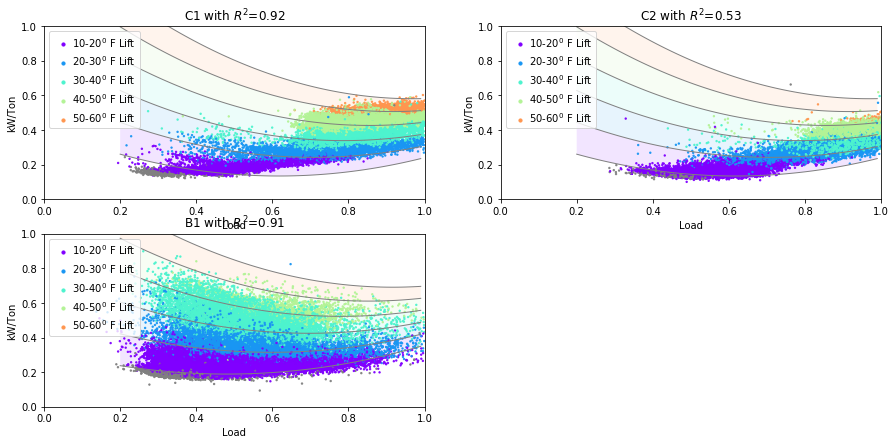

In [80]:
plot_all_curves(['C1','C2','B1'],feat,lr,savefile)

## test multiple plants, plot in subplots

In [8]:
#'''
ChList = (['1T1','1T2','1T3','1T4','1T5','1T7','1T8','1T9','1T10','1T11','1T12',
             '5T1','5T2','5T3','5T4',
             'B1','B2','B3','B4',
             'BC1','BC2',
             'C1','C2','C3','C4',
             'S1','S2','S3','S4'])
#'''

#ChList = (['S1'])

#ChList = (['BB1'])
#ChList = (['B1','B2','B3','B4',
#             'C1','C2','C3','C4',
#             'S1','S2','S3','S4'])


df_all = Plants_to_one_file(ChList)
data_file = 'data/ALL_chillers.csv'
df_all.to_csv(data_file)

opening file: data/1T1_chiller.csv        plant code: 1T        chiller code: 1
opening file: data/1T2_chiller.csv        plant code: 1T        chiller code: 2
opening file: data/1T3_chiller.csv        plant code: 1T        chiller code: 3
opening file: data/1T4_chiller.csv        plant code: 1T        chiller code: 4
opening file: data/1T5_chiller.csv        plant code: 1T        chiller code: 5
opening file: data/1T7_chiller.csv        plant code: 1T        chiller code: 7
opening file: data/1T8_chiller.csv        plant code: 1T        chiller code: 8
opening file: data/1T9_chiller.csv        plant code: 1T        chiller code: 9
opening file: data/1T10_chiller.csv        plant code: 1T        chiller code: 10
opening file: data/1T11_chiller.csv        plant code: 1T        chiller code: 11
opening file: data/1T12_chiller.csv        plant code: 1T        chiller code: 12
opening file: data/5T1_chiller.csv        plant code: 5T        chiller code: 1
opening file: data/5T2_chiller.csv

### PYMC3 things to try   

advi -automatic differentiation variational inference
rather than sampling use a parametrized ...
find parameters that minimize inference

do non-centered on the parameterization


In [9]:
TypeModel = 'LinearRegression'
#TypeModel = 'RandomForestRegressor'
#TypeModel = 'PyMC3_H'
#TypeModel = 'PyMC3_2'

#feat = ['HigherOrder','ModelInfo']
#feat = ['HigherOrder','ReducedModelInfo','ModelInfoHigherOrder']
#feat = ['HigherOrder','ReducedModelInfo']
feat = ['HigherOrder']

X, y, df = new_get_Xy(data_file,feat)

if 'PyMC3' in TypeModel:
    X_orig, y, df = new_get_Xy(data_file,feat)
    X_scaler = StandardScaler()
    X = pd.DataFrame(X_scaler.fit_transform(X_orig), columns=X_orig.columns)

#df_Xy = pd.concat([y, X], axis=1)
#df_Xy['kWTon'] = df_Xy['kW/Ton']
#df_Xy['Load2'] = df_Xy['Load^2']
#df_Xy['LoadDTLift'] = df_Xy['Load*DTLift']
#df_Xy['Load2DTLift'] = df_Xy['Load^2*DTLift']

print(X.shape)
#print(X.dropna().shape)

#divide in to train and test sets
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

if TypeModel == 'LinearRegression':
    print
    # Create an empty model
    lr = LinearRegression()
    model = lr

    pickle.dump(lr,open('lr.pkl','wb'))

    # Fit the model to the full dataset
    lr.fit(X_train, y_train)

    # Print out the R^2 for the model against the full dataset
    print(lr.intercept_)
    print(lr.coef_)

elif TypeModel == 'RandomForestRegressor':
    regr = RandomForestRegressor(max_depth=6, random_state=0,
                                 n_estimators=100)
    model = regr
    
    regr.fit(X_train, y_train)
    print(regr.feature_importances_)

elif TypeModel == 'PyMC3GLM':
    with pm.Model() as model:
        pm.glm.GLM.from_formula('kWTon ~ Load + Load2 + DTLift + LoadDTLift + Load2DTLift', df_Xy)
        trace = pm.sample(2000, cores=4)
        
elif TypeModel == 'PyMC3GLMt':
    with pm.Model() as model:
        family = pm.glm.families.StudentT()
        pm.glm.GLM.from_formula('kWTon ~ Load + Load2 + DTLift + LoadDTLift + Load2DTLift', df_Xy, family=family)

        trace_robust = pm.sample(2000, cores=4)

elif TypeModel == 'PyMC3_2':
    with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
        # Define priors
        sigma = HalfCauchy('sigma', beta=10)
        inter = Normal('Intercept', 0, sd=.01)
        #sd0 = Normal('coed_sd',0,1)
        #sd1 = 
        D_coef = Normal('Load', 0, sd=.01)
        D2_coef = Normal('Load2', 0, sd=.01)
        DT_coef = Normal('LoadLift', 0, sd=.01)
        D2T_coef = Normal('Load2Lift', 0, sd=.01)
        T_coef = Normal('Lift', 0, sd=.01)

        # Define likelihood
        likelihood = Normal('kWTon', mu=inter + 
                            D_coef * X['Load'] + D2_coef*X['Load^2'] + T_coef*X['DTLift']
                            + DT_coef*X['Load^2*DTLift'] + 
                            D2T_coef*X['Load^2*DTLift']
                            ,sd=sigma, observed=y)
#        likelihood = Normal('kWTon', mu=inter + T_coef*X['DTLift'] + 
#                            (D_coef  + DT_coef*X['DTLift'])*X['Load'] +
#                            (D2_coef + D2T_coef*X['DTLift'])*X['Load^2']
#                            ,sd=sigma, observed=y)

        # Inference!
        trace = sample(400) # draw posterior samples using NUTS sampling

elif TypeModel == 'PyMC3_H':
    with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
        # Define priors
        kWTon_sigma = HalfCauchy('kWTon_sigma', beta=10)
        kWTon_intercept = Cauchy('Intercept', alpha=0, beta=10)
        D2_coef = Cauchy('Load2', beta=10, alpha=0)
#        DT_coef = Normal('LoadLift', 0, sd=1)
#        D2T_coef = Normal('Load2Lift', 0, sd=20)
#        T_coef = Normal('Lift', 0, sd=20)
        
        D_coef_RT       = Normal('D_coef_RT', 0, sd=20)
        D_coef_RT_sigma = HalfCauchy('D_coef_RT_sigma', beta=10, testval=1.)
        D_coef_int   = Cauchy('D_coef_RT_int', alpha=0,beta=10, testval=1.)
        
        D_coef = Normal('D_coef', mu = D_coef_int + D_coef_RT*X['RatedTons'], sd=D_coef_RT_sigma)

        # Define likelihood
        kWTon = Normal('kWTon', mu=kWTon_intercept + 
                            D_coef * X['Load'] + D2_coef*X['Load^2'] 
#                           + DT_coef*X['Load^2*DTLift'] + 
#                            D2T_coef*X['Load^2*DTLift'] + T_coef*X['DTLift']
                            ,sd=kWTon_sigma, observed=y)

        # Inference!
        trace = sample() # draw posterior samples using NUTS sampling


DataFrame rows with NaN removed:  35600
X with all features (923837, 5)
(923837, 5)
(554302, 5) (554302,)
(369535, 5) (369535,)
0.176972447728464
[-0.6552131   0.02107035  0.56942507 -0.00747857 -0.00426186]


In [198]:
df.columns

Index(['index', 'Unnamed: 0', 'Unnamed: 0.1', 'datetime', 'kW/Ton', 'Load',
       'CDWRT', 'CDWST', 'DTLift', 'Ton', 'EvapApproach', 'CondApproach', 'Hz',
       'CompSH', 'IGV', 'REFLVL', 'ModelNo', 'Chiller', 'RatedTons',
       'VarSpeed', 'RatedkW', 'CDesFlow', 'CPDrop', 'CEnterTemp', 'CLeaveTemp',
       'EDesFlow', 'EPDrop', 'EEnterTemp', 'ELeaveTemp'],
      dtype='object')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

getting model info
opening file: data/B1_chiller.csv        plant code: B        chiller code: 1
DataFrame rows with NaN removed:  132
X with all features (32881, 5)
Chiller B1: RMSE=0.03526111839069855, R2=0.9283864038240528
 


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

getting model info
opening file: data/B2_chiller.csv        plant code: B        chiller code: 2
DataFrame rows with NaN removed:  191
X with all features (35192, 5)
Chiller B2: RMSE=0.03909876429171874, R2=0.8766452721803651
 


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

getting model info
opening file: data/B3_chiller.csv        plant code: B        chiller code: 3
DataFrame rows with NaN removed:  83
X with all features (29027, 5)
Chiller B3: RMSE=0.03180185879264806, R2=0.931567284096249
 


ValueError: setting an array element with a sequence

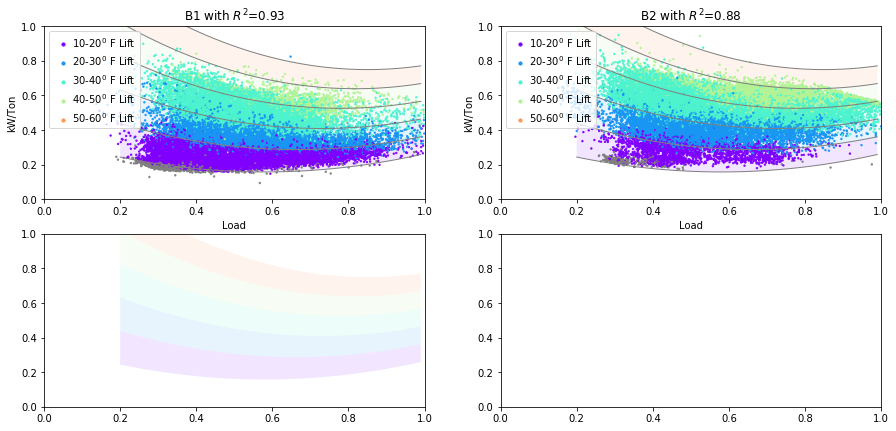

In [190]:
#savefile = '1T_5T_BC_B_C_S.pdf'
#ChList = (['B1','B4'])

savefile = ''
plot_all_curves(ChList,feat,model,savefile)

No handles with labels found to put in legend.


IndexError: list index out of range

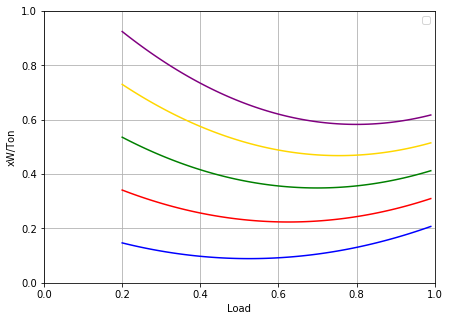

In [192]:
Chiller = 'B1'
lift_lines = compute_lift_lines(model, feat, df, plot=True)

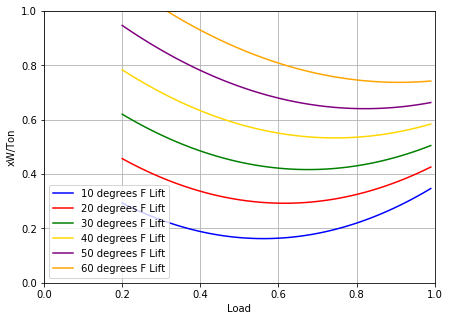

In [195]:
Chiller = 'B1'
pymc3_lift_lines = compute_lift_lines_pymc3(pymc3_coef, X_scaler, feat, plot=True)
pickle.dump(pymc3_lift_lines,open(Chiller+'pymc3_lift_lines.pkl','wb'))


Things to try:   
move Lift, Load to center on zero

/anaconda3/envs/ppp/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/anaconda3/envs/ppp/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/anaconda3/envs/ppp/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/anaconda3/envs/ppp/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alter

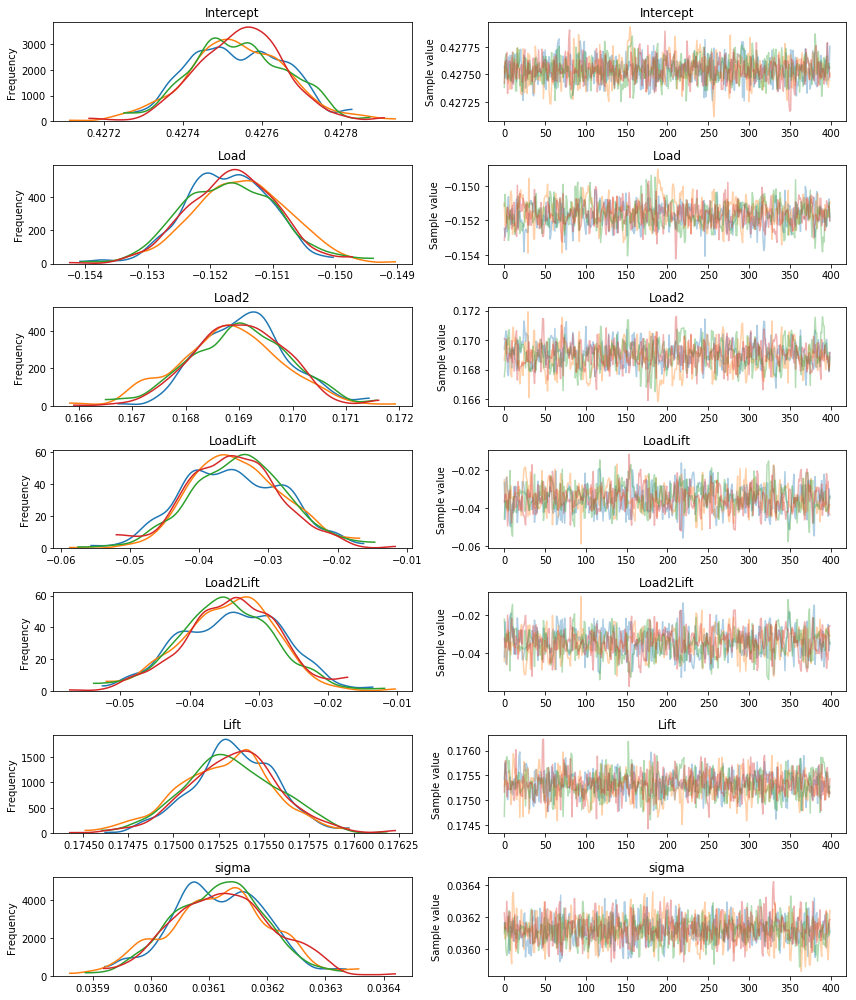

In [197]:
pm.traceplot(trace);


In [188]:
0.2834464018583932
[-0.12157803  0.06040579  0.13707445  0.08557134 -0.08809359]

SyntaxError: invalid syntax (<ipython-input-188-1f54356267e2>, line 2)

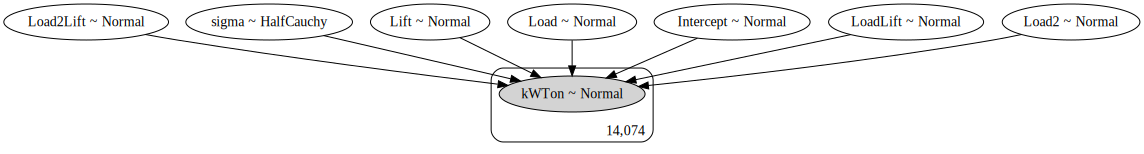

In [120]:
model_to_graphviz(model)

In [100]:
X.columns

Index(['Load', 'DTLift', 'Load^2', 'Load*DTLift', 'Load^2*DTLift'], dtype='object')

In [194]:
pymc3_coef = pm.trace_to_dataframe(trace).mean()

No handles with labels found to put in legend.


lift= 5
X_line shape (80, 5)
pymc3_coef Intercept    0.283506
Load        -0.072610
Load2        0.084325
LoadLift    -0.009633
Load2Lift   -0.009734
Lift         0.087055
sigma        0.009265
dtype: float64
0.2835055058047315 -0.07261043673737602 0.08432480288120324 -0.009633248398396674 -0.009733847773008227 0.08705480002047271
Index(['Load', 'DTLift', 'Load^2', 'Load*DTLift', 'Load^2*DTLift'], dtype='object')
(80, 5)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

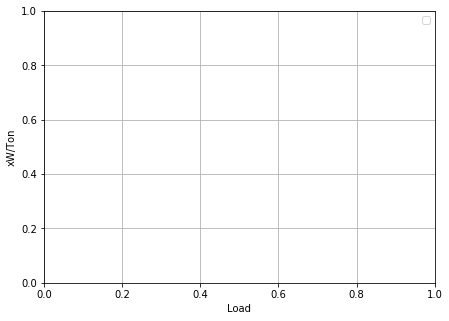

In [158]:
compute_lift_lines_pymc3(pymc3_coef, X_scaler, feat, plot=True)

In [25]:
X.columns

Index(['Load', 'DTLift', 'Load^2', 'Load*DTLift', 'Load^2*DTLift', 'RatedTons',
       'VarSpeed', 'CDesFlow', 'RatedTons_Load', 'RatedTons_Load^2',
       'CDF_Load', 'CDF_Load^2', 'CPD_Load', 'CPD_Load^2', 'EDF_Load',
       'EDF_Load^2', 'EDP_Load', 'EDP_Load^2'],
      dtype='object')

RandomForestRegressor   

Max_Depth = 2, n_estimators=100 .   R^2 = .78   
Max_Depth = 4, n_estimators=100 .   R^2 = .88   
Max_Depth = 4, n_estimators=200 .   R^2 = .88   
Max_Depth = 6, n_estimators=100 .   R^2 = .91   


In [201]:
print('train: ',model.score(X_train,y_train))
print('test : ',model.score(X_test,y_test))

train:  0.9872559950915218
test :  0.985679404254821


getting model info
opening file: data/1T1_chiller.csv        plant code: 1T        chiller code: 1
DataFrame rows with NaN removed:  3
X with all features (52990, 5)
Chiller 1T1: RMSE=0.043076201232004764, R2=0.21978817574229803


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

getting model info
opening file: data/1T2_chiller.csv        plant code: 1T        chiller code: 2
DataFrame rows with NaN removed:  0
X with all features (37681, 5)
Chiller 1T2: RMSE=0.03823440803072429, R2=0.3957126441571326
 


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

getting model info
opening file: data/1T3_chiller.csv        plant code: 1T        chiller code: 3
DataFrame rows with NaN removed:  0
X with all features (8224, 5)
Chiller 1T3: RMSE=0.06307882799183707, R2=-1.0509220470310403
 


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

getting model info
opening file: data/1T4_chiller.csv        plant code: 1T        chiller code: 4
DataFrame rows with NaN removed:  0
X with all features (18766, 5)
Chiller 1T4: RMSE=0.09719749355075871, R2=-7.465202233848252
 


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

getting model info
opening file: data/1T5_chiller.csv        plant code: 1T        chiller code: 5
DataFrame rows with NaN removed:  0
X with all features (29916, 5)
Chiller 1T5: RMSE=0.11155542269269471, R2=-5.036049051608767
 
getting model info
opening file: data/1T7_chiller.csv        plant code: 1T        chiller code: 7
DataFrame rows with NaN removed:  34
X with all features (76738, 5)
Chiller 1T7: RMSE=0.05583520257005669, R2=0.10006252527184767


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

 
getting model info
opening file: data/1T8_chiller.csv        plant code: 1T        chiller code: 8
DataFrame rows with NaN removed:  18
X with all features (59917, 5)
Chiller 1T8: RMSE=0.03924370130469486, R2=0.7276171084808731


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

getting model info
opening file: data/1T9_chiller.csv        plant code: 1T        chiller code: 9
DataFrame rows with NaN removed:  14
X with all features (34187, 5)
Chiller 1T9: RMSE=0.06045163755355154, R2=-0.055950038814245096
 


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

getting model info
opening file: data/1T10_chiller.csv        plant code: 1T        chiller code: 10
DataFrame rows with NaN removed:  3
X with all features (23140, 5)
Chiller 1T10: RMSE=0.0886081457914493, R2=-0.10843785889324797
 


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

getting model info
opening file: data/1T11_chiller.csv        plant code: 1T        chiller code: 11
DataFrame rows with NaN removed:  14
X with all features (20120, 5)
Chiller 1T11: RMSE=0.06318886357277512, R2=0.294120842052066
 
getting model info
opening file: data/1T12_chiller.csv        plant code: 1T        chiller code: 12
DataFrame rows with NaN removed:  18
X with all features (62826, 5)
Chiller 1T12: RMSE=0.05282122025415984, R2=0.0819775825394391


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

 
getting model info
opening file: data/5T1_chiller.csv        plant code: 5T        chiller code: 1
DataFrame rows with NaN removed:  1054
X with all features (48642, 5)
Chiller 5T1: RMSE=0.0972550719121447, R2=-1.645181849818099


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

getting model info
opening file: data/5T2_chiller.csv        plant code: 5T        chiller code: 2
DataFrame rows with NaN removed:  235
X with all features (20378, 5)
Chiller 5T2: RMSE=0.11987477730298719, R2=-9.168183399380258
 


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

getting model info
opening file: data/5T3_chiller.csv        plant code: 5T        chiller code: 3
DataFrame rows with NaN removed:  638
X with all features (19090, 5)
Chiller 5T3: RMSE=0.05922377360424818, R2=-1.0344416496714284
 


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

getting model info
opening file: data/5T4_chiller.csv        plant code: 5T        chiller code: 4
DataFrame rows with NaN removed:  188
X with all features (20251, 5)
Chiller 5T4: RMSE=0.07106550775024095, R2=-0.6130813795856702
 


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

getting model info
opening file: data/B1_chiller.csv        plant code: B        chiller code: 1
DataFrame rows with NaN removed:  132
X with all features (32881, 5)
Chiller B1: RMSE=0.046002661479005245, R2=0.8781096752385233
 


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

getting model info
opening file: data/B2_chiller.csv        plant code: B        chiller code: 2
DataFrame rows with NaN removed:  191
X with all features (35192, 5)
Chiller B2: RMSE=0.040229109712150546, R2=0.8694098024644262
 


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

getting model info
opening file: data/B3_chiller.csv        plant code: B        chiller code: 3
DataFrame rows with NaN removed:  83
X with all features (29027, 5)
Chiller B3: RMSE=0.04998926839260036, R2=0.8309121787871447
 


ValueError: setting an array element with a sequence

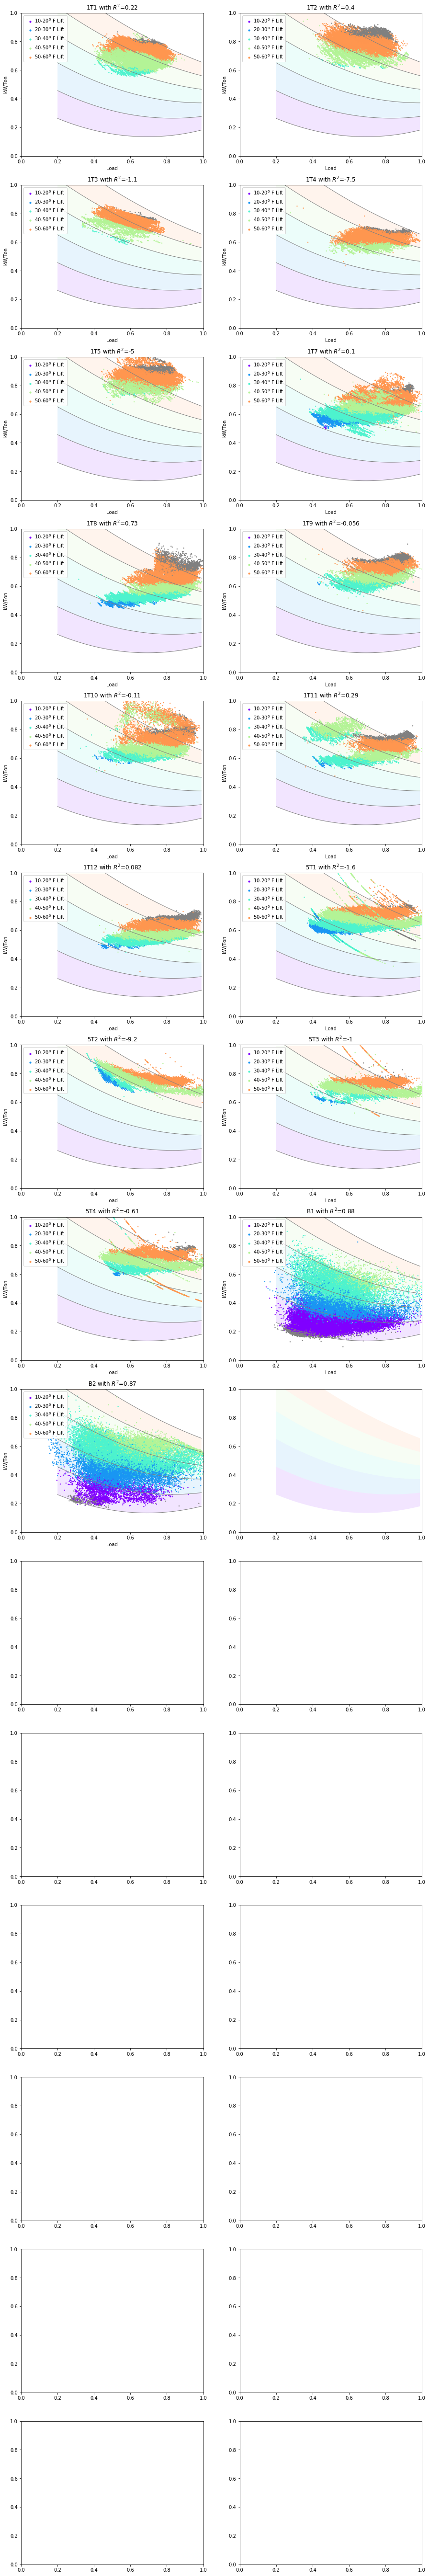

In [10]:
#savefile = '1T_5T_BC_B_C_S.pdf'
#ChList = (['S4'])

savefile = ''
plot_all_curves(ChList,feat,model,savefile)